# Transformer Inference: PyTorch → ONNX (Performance and Accuracy Analysis)

**Objective:**

This notebook demonstrates how to convert a PyTorch model into ONNX and then run it with ONNX Runtime, focusing on:
1. Baseline PyTorch inference latency
2. Exporting the model to ONNX
3. Running ONNX inference on GPU and CPU
4. Validating numerical equivalence
5. Measuring performance impact
6. Simplifying the ONNX graph for downstream accelerators (e.g., TensorRT)

We measure:
- **Latency per inference**
- **Relative speedup compared to PyTorch**

**What is ONNX?**

ONNX (Open Neural Network Exchange) is an open standard format for representing machine learning models. Think of it as a universal language that allows models trained in one framework (e.g., PyTorch, TensorFlow) to be exported and executed in another environment or runtime (such as ONNX Runtime, TensorRT, or OpenVINO).

## Environment Setup



The initial cells install required dependencies:
- `nvidia_modelopt`: utilities for model optimization workflows
- `onnx, onnxscript`: ONNX graph export and manipulation
- `onnxruntime-gpu`: high-performance inference runtime with CUDA support

In [ ]:
!pip install -U "nvidia_modelopt[hf]"
!pip install onnxscript onnx onnxruntime-gpu

In [1]:
import torch
import onnx

print(f"PyTorch: {torch.__version__}")
print(f"PyTorch CUDA: {torch.version.cuda}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"Onnx: {onnx.__version__}")

PyTorch: 2.9.0+cu126
PyTorch CUDA: 12.6
CUDA available: True
Onnx: 1.20.1


## Model Loading and Input Preparation

The model and tokenizer are loaded using Hugging Face Transformers. This model serves as a proxy for larger sequence models used in production.

The experiment uses RoBERTa-base as a representative Transformer encoder.

In [ ]:
import time
import torch
from transformers import AutoTokenizer, AutoModel

# 1. Load model & tokenizer
model_name = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name).eval().cuda()

# 2. Example batch of sentences
text = """ A good story encourages us to turn the next page and read more. We want to find out what happens next and what the main characters do and what they say to each other.
We may feel excited, sad, afraid, angry or really happy. This is because the experience of reading or listening to a story is much more likely to make us 'feel' that we are part
of the story, too. Just like in our 'real' lives, we might love or hate different characters in the story. Perhaps we recognise ourselves or others in some of them. Perhaps we
have similar problems. Because of this natural empathy with the characters, our brains process the reading of stories differently from the way we read factual information.
Our brains don't always recognise the difference between an imagined situation and a real one so the characters become 'alive' to us. What they say and do is therefore more meaningful.
This is why the words and structures that relate a story's events, descriptions and conversations are processed in this deeper way. In fact, cultures all around the world have always
used storytelling to pass knowledge from one generation to another. Our ancestors understood very well that this was the best way to make sure our histories and information about
how to relate to others and to our world was not only understood, but remembered too. (Notice that the word ‘history’ contains the word ‘story’ – More accurately, the word ‘story’
derives from ‘history’.) Encouraging your child to read or listen to stories should therefore help them to learn a second language in a way that is not only fun, but memorable.
Let's take a quick look at learning vocabulary within a factual text or within a story. Imagine the readers are eight-year-olds interested in animals. In your opinion, are they more
likely to remember AND want to continue reading the first or second text? """

texts = [item.strip() for item in text.split(".")][:16]  # adjust batch size here
inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=32).to("cuda")

input_ids = inputs["input_ids"].to(torch.int32)
attention_mask = inputs["attention_mask"].to(torch.int32)


## Baseline: Native PyTorch Inference

The baseline measurement serves as the ground truth for both:
- Latency comparison
- Numerical correctness

Key points:

- `torch.no_grad()` disables gradient tracking

- `torch.cuda.synchronize()` ensures accurate GPU timing

Output:
- `last_hidden_state` tensor of shape (batch_size, seq_len, hidden_dim)

This output is later used as the reference for ONNX validation.

In [3]:
# 3. Baseline PyTorch inference

with torch.no_grad():
    start = time.time()
    baseline_outputs = model(input_ids, attention_mask)
    torch.cuda.synchronize()
    end = time.time()
    baseline_time = end - start
    print(f"PyTorch latency: {baseline_time:.4f} sec")

print("Output shape (PyTorch):", baseline_outputs.last_hidden_state.shape)

PyTorch latency: 0.6441 sec
Output shape (PyTorch): torch.Size([16, 32, 768])


## Export to ONNX

The model is exported using `torch.onnx.export` with:
- Dynamic axes for batch size and sequence length
- Explicit input/output naming

Why this matters:
- Dynamic axes make the ONNX model reusable for variable-length inputs
- Clean I/O naming simplifies deployment and debugging

The resulting ONNX graph is framework-agnostic and ready for multiple runtimes.

In [ ]:
# save to onnx
output_onnx_file = "roberta.onnx"
torch.onnx.export(
    model.float(),
    (input_ids, attention_mask),
    output_onnx_file,
    input_names=["input_ids", "attention_mask"],
    output_names=["logits", "other"],
    dynamic_axes={
        "input_ids": {0: "batch_size", 1: "seq_len"},
        "attention_mask": {0: "batch_size", 1: "seq_len"},
        "logits": {0: "batch_size", 1: "seq_len"},
        "other": {0: "batch_size"}
    },
    opset_version=17
)

print("save to onnx file:", output_onnx_file)

## ONNX Runtime Inference

ONNX Runtime is used with two execution providers:
- `CUDAExecutionProvider`
- `CPUExecutionProvider`

For each run, the notebook records:
- End-to-end inference latency
- Raw output tensors

This highlights how the same exported model behaves across hardware backends.

In [5]:
import onnxruntime as ort
import numpy as np

def run_onnx(onnx_model_pth, provider: str):
    input_ids_np = inputs["input_ids"].to(torch.int32).cpu().numpy()
    attention_mask_np = inputs["attention_mask"].to(torch.int32).cpu().numpy()

    # 4. Onnx inference
    sess = ort.InferenceSession(onnx_model_pth, providers=[provider])

    # Check available providers
    print("Available providers:", ort.get_available_providers())
    print("Current provider:", sess.get_providers())

    start = time.time()
    onnx_outputs = sess.run(None, {"input_ids": input_ids_np, "attention_mask": attention_mask_np})
    end = time.time()
    onnx_time = end - start
    print(f"onnx runtime latency: {onnx_time:.4f} sec")
    return onnx_outputs, onnx_time

def measure_numeric_diff(onnx_tensor, pytorch_base_tensor):
    diff = np.abs(pytorch_base_tensor - onnx_tensor)
    diff_mean = diff.mean()
    diff_max = diff.max()
    diff_percent = (diff > 0.01).mean() * 100

    print("  Mean absolute difference:", diff_mean)
    print("  Max absolute difference:", diff_max)
    print("  Percentage of values with diff > 0.01:", diff_percent, "%")

    return diff, diff_mean, diff_max, diff_percent

## Performance Evaluation (ONNX)


Performance gains are meaningless without correctness. We compare:
- PyTorch outputs
- ONNX Runtime (GPU & CPU) outputs

**Metrics:**
- Absolute difference
- Relative error tolerance

**Interpretation:**
- Small numerical differences are expected due to kernel and precision differences
- Low error rates confirm that ONNX faithfully reproduces PyTorch behavior

### ONNX GPU Inference: Numerical Difference

In [6]:
onnx_outputs, onnx_time = run_onnx("roberta.onnx", "CUDAExecutionProvider")

onnx_tensor = onnx_outputs[0]  # for last_hidden_state
pytorch_base_tensor = baseline_outputs.last_hidden_state.cpu().numpy()

print("\nNumeric differences ONNX (GPU):")
onnx_values = measure_numeric_diff(onnx_tensor, pytorch_base_tensor)

Available providers: ['TensorrtExecutionProvider', 'CUDAExecutionProvider', 'CPUExecutionProvider']
Current provider: ['CUDAExecutionProvider', 'CPUExecutionProvider']
onnx runtime latency: 0.1381 sec

Numeric differences ONNX (GPU):
  Mean absolute difference: 2.2379454e-07
  Max absolute difference: 1.04904175e-05
  Percentage of values with diff > 0.01: 0.0 %


### ONNX CPU Inference: Numerical Difference

In [7]:
onnx_outputs_cpu, onnx_cpu_time = run_onnx("roberta.onnx", "CPUExecutionProvider")

onnx_tensor_cpu = onnx_outputs_cpu[0]  # for last_hidden_state
pytorch_base_tensor = baseline_outputs.last_hidden_state.cpu().numpy()

print("\nNumeric differences ONNX (CPU):")
onnx_cpu_values = measure_numeric_diff(onnx_tensor_cpu, pytorch_base_tensor)

Available providers: ['TensorrtExecutionProvider', 'CUDAExecutionProvider', 'CPUExecutionProvider']
Current provider: ['CPUExecutionProvider']
onnx runtime latency: 0.9546 sec

Numeric differences ONNX (CPU):
  Mean absolute difference: 3.1360017e-07
  Max absolute difference: 1.7166138e-05
  Percentage of values with diff > 0.01: 0.0 %


### Inference: Time Comparison

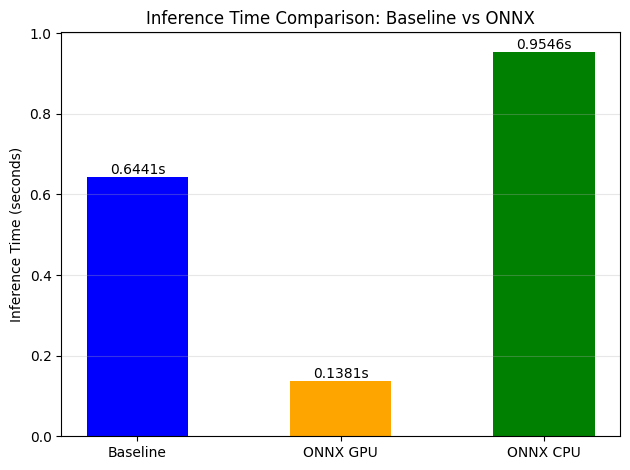

In [9]:
import matplotlib.pyplot as plt

inference_time = [baseline_time, onnx_time, onnx_cpu_time]
labels = ['Baseline', 'ONNX GPU', 'ONNX CPU']

# Create bar chart
bars = plt.bar(labels, inference_time, width=0.5, color=['blue', 'orange', 'green'])

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}s',
             ha='center', va='bottom', fontsize=10)

plt.ylabel('Inference Time (seconds)')
plt.title('Inference Time Comparison: Baseline vs ONNX')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

**Observations:**

- ONNX GPU ≈ PyTorch or faster
- ONNX CPU significantly slower than GPU

## Simplify ONNX

If we want to further simplify the ONNX model before passing it to TensorRT, we need to install the `onnxsim` module. However, on Colab, we may encounter a build issue. This is because onnxsim doesn’t provide prebuilt wheels for Python 3.12 (the default Python version on Colab), so pip falls back to building from source (setup.py). This process can be slow and may fail if the necessary build tools aren’t installed.

We can use the following code to build onnxsim on Colab:

In [ ]:
!apt-get install -y build-essential cmake
!pip install --upgrade pip setuptools wheel
!pip install onnxsim --use-pep517 --no-build-isolation

In [10]:
!onnxsim roberta.onnx roberta_simplified.onnx

Simplifying...
Finish! Here is the difference:
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃                    ┃ Original Model ┃ Simplified Model ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ Add                │ 123            │ 123              │
│ Cast               │ 6              │ 6                │
│ Concat             │ 28             │ 28               │
│ Constant           │ 217            │ 216              │
│ CumSum             │ 1              │ 1                │
│ Div                │ 12             │ 12               │
│ Equal              │ 1              │ 1                │
│ Erf                │ 12             │ 12               │
│ Expand             │ 2              │ 2                │
│ Gather             │ 4              │ 4                │
│ Gemm               │ 1              │ 1                │
│ LayerNormalization │ 25             │ 25               │
│ MatMul             │ 96             │ 96               │
│ Mul    

## Performance Evaluation (ONNX Simplified)

### GPU Inference: Numerical Difference

In [11]:
onnx_outputs_simplified, onnx_simplified_time = run_onnx("roberta_simplified.onnx", "CUDAExecutionProvider")

onnx_tensor_simplified = onnx_outputs_simplified[0]  # for last_hidden_state
pytorch_base_tensor = baseline_outputs.last_hidden_state.cpu().numpy()

print("\nNumeric differences ONNX Simplified (GPU):")
onnx_simplified_values = measure_numeric_diff(onnx_tensor_simplified, pytorch_base_tensor)

Available providers: ['TensorrtExecutionProvider', 'CUDAExecutionProvider', 'CPUExecutionProvider']
Current provider: ['CUDAExecutionProvider', 'CPUExecutionProvider']
onnx runtime latency: 0.0429 sec

Numeric differences ONNX Simplified (GPU):
  Mean absolute difference: 2.2379454e-07
  Max absolute difference: 1.04904175e-05
  Percentage of values with diff > 0.01: 0.0 %


### CPU Inference: Numerical Difference

In [12]:
onnx_outputs_simplified_cpu, onnx_simplified_cpu_time = run_onnx("roberta_simplified.onnx", "CPUExecutionProvider")

onnx_tensor_simplified_cpu = onnx_outputs_simplified_cpu[0]  # for last_hidden_state
pytorch_base_tensor = baseline_outputs.last_hidden_state.cpu().numpy()

print("\nNumeric differences ONNX Simplified (CPU):")
onnx_simplified_cpu_values = measure_numeric_diff(onnx_tensor_simplified_cpu, pytorch_base_tensor)

Available providers: ['TensorrtExecutionProvider', 'CUDAExecutionProvider', 'CPUExecutionProvider']
Current provider: ['CPUExecutionProvider']
onnx runtime latency: 0.8921 sec

Numeric differences ONNX Simplified (CPU):
  Mean absolute difference: 3.1360017e-07
  Max absolute difference: 1.7166138e-05
  Percentage of values with diff > 0.01: 0.0 %


## Final Results Comparison

In [13]:
import pandas as pd
import numpy as np

data_comparison = pd.DataFrame({
    "Model": ['PyTorch Baseline', 'ONNX GPU', 'ONNX CPU', 'ONNX Simplified GPU', 'ONNX Simplified CPU'],
    "Inference Time (s)": [baseline_time, onnx_time, onnx_cpu_time, onnx_simplified_time, onnx_simplified_cpu_time],
    "Above Threshold % (0.01)": [np.nan, onnx_values[3], onnx_cpu_values[3], onnx_simplified_values[3], onnx_simplified_cpu_values[3]]
}).set_index('Model')

display(data_comparison)

,Inference Time (s),Above Threshold % (0.01)
Model,,
PyTorch Baseline,0.644051,NaN
ONNX GPU,0.138149,0.0
ONNX CPU,0.954613,0.0
ONNX Simplified GPU,0.042859,0.0
ONNX Simplified CPU,0.892069,0.0


**Obervations:**

The converted ONNX model doesn’t show a significant performance boost. In this notebook, the model is still exported in the default FP32 format rather than being compressed to FP16. Using FP32 ensures maximum compatibility. Most operations are supported, and the weights remain safe. Later, while building with the TensorRT engine, we can enable FP16. TensorRT will then automatically convert supported layers to FP16 while keeping sensitive layers in FP32 as needed.

As a universal format, ONNX is usually not the final destination. It can be further converted into a TensorRT engine, which allows direct control over dynamic shapes, precision, and GPU memory during inference.